# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [3]:
# Load the data files from https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

import os

if not os.path.exists('penguins_raw.csv'):
    !wget https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/data-raw/penguins_raw.csv

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig, write_table

In [5]:
df = pd.read_csv('penguins_raw.csv')

In [6]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [7]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

In [8]:
def make_cdfs(df, varname):
    grouped = df.groupby('Species2')[varname]
    t = [Cdf.from_seq(group, name=species)
         for species, group in grouped]
    return t

In [9]:
def plot_cdfs(df, varname):
    cdfs = make_cdfs(df, varname)
    
    for cdf in cdfs:
        cdf.plot()
    
    decorate(xlabel=varname,
             ylabel='CDF')

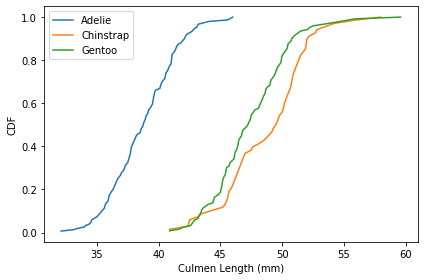

In [10]:
varname = 'Culmen Length (mm)'
plot_cdfs(df, varname)

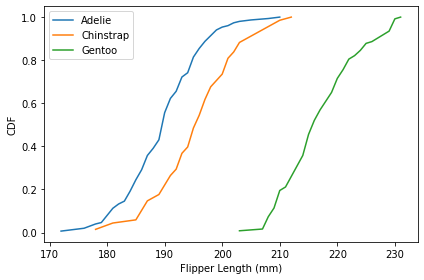

In [11]:
varname = 'Flipper Length (mm)'
plot_cdfs(df, varname)

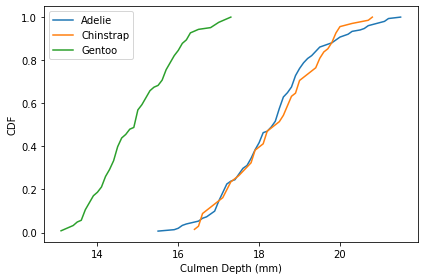

In [12]:
varname = 'Culmen Depth (mm)'
plot_cdfs(df, varname)

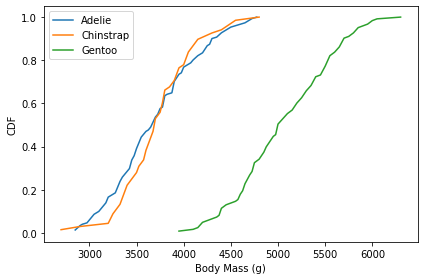

In [13]:
varname = 'Body Mass (g)'
plot_cdfs(df, varname)

In [14]:
from scipy.stats import norm

def make_norm_map(df, varname):
    """Make a map from species to norm object.
    
    df: DataFrame
    varname: string column name
    
    returns: dictionary from species name to norm object
    """
    norm_map = {}
    grouped = df.groupby('Species2')[varname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

In [15]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map

{'Adelie': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f36a1a4ad90>,
 'Chinstrap': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f36a1a4ad00>,
 'Gentoo': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f36a13588e0>}

In [16]:
hypos = flipper_map.keys()
prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


In [17]:
data = 210
flipper_map['Adelie'].pdf(data)

0.0005557043153857454

In [18]:
likelihood = [flipper_map[hypo].pdf(data) 
              for hypo in hypos]
likelihood

[0.0005557043153857454, 0.007757433347055787, 0.03328865501748979]

In [19]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.013358
Chinstrap,0.186469
Gentoo,0.800174


In [20]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species.
    
    prior: Pmf
    data: 
    norm_map: map from hypothesis to distribution of data
    
    returns: posterior Pmf
    """
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) 
                  for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

In [21]:
update_penguin(prior, 210, flipper_map)

,probs
Adelie,0.013358
Chinstrap,0.186469
Gentoo,0.800174


In [22]:
update_penguin(prior, 190, flipper_map)

,probs
Adelie,0.603445
Chinstrap,0.396463
Gentoo,0.000093


In [23]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')
update_penguin(prior, 38, culmen_map)

,probs
Adelie,0.988058
Chinstrap,0.004266
Gentoo,0.007675


In [24]:
update_penguin(prior, 48, culmen_map)

,probs
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


In [25]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

In [26]:
varnames = ['Culmen Length (mm)', 'Flipper Length (mm)']
norm_maps = [culmen_map, flipper_map]

In [27]:
data_seq = 48, 210
update_naive(prior, data_seq, norm_maps)

,probs
Adelie,0.000041
Chinstrap,0.174351
Gentoo,0.825608


In [29]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[varnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.idxmax()

In [30]:
len(df)

344

In [31]:
valid = df['Classification'].notna()
valid.sum()

342

In [32]:
same = df['Species2'] == df['Classification']
same.sum()

324

In [33]:
same.sum() / valid.sum()

0.9473684210526315

In [34]:
def accuracy(df):
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

In [35]:
def scatter_plot(df, var1, var2):
    """
    """
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var2], group[var1], 'o',
                 alpha=0.4, label=species)
    
    decorate(ylabel=var1, xlabel=var2)

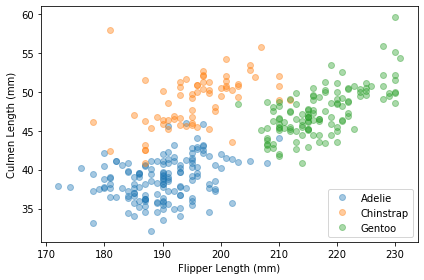

In [36]:
var1 = 'Culmen Length (mm)'
var2 = 'Flipper Length (mm)'

scatter_plot(df, var1, var2)

In [38]:
def make_pmf(dist):
    """
    """
    mean, std = dist.mean(), dist.std()
    qs = np.linspace(mean-3*std, mean+3*std, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [37]:
from utils import outer_product

In [39]:
joint_map = {}

for species in hypos:
    pmf1 = make_pmf(culmen_map[species])
    pmf2 = make_pmf(flipper_map[species])
    joint_map[species] = outer_product(pmf1, pmf2)

In [40]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.contour(joint.columns, joint.index, joint, **options)

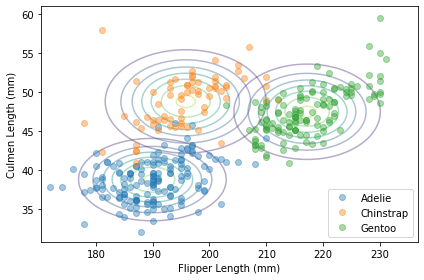

In [65]:
scatter_plot(df, var1, var2)

for species in hypos:
    plot_contour(joint_map[species], alpha=0.4)

In [66]:
features = df[[var1, var2]]
features.head()

,Culmen Length (mm),Flipper Length (mm)
0,39.1,181.0
1,39.5,186.0
2,40.3,195.0
3,NaN,NaN
4,36.7,193.0


In [67]:
mean = features.mean()
mean

Culmen Length (mm)      43.921930
Flipper Length (mm)    200.915205
dtype: float64

In [68]:
cov = features.cov()
cov

,Culmen Length (mm),Flipper Length (mm)
Culmen Length (mm),29.807054,50.375765
Flipper Length (mm),50.375765,197.731792


In [69]:
from scipy.stats import multivariate_normal

multinorm = multivariate_normal(mean, cov)
multinorm

In [70]:
def make_multinorm_map(df, varnames):
    """Make a map from each species to a multivariate normal.
    
    df: DataFrame
    varnames: list of string column names
    
    returns: map from species name to multivariate_normal
    """
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[varnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

In [71]:
multinorm_map = make_multinorm_map(df, [var1, var2])
multinorm_map

{'Adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f3699e5db80>,
 'Chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f3699e5dd60>,
 'Gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f3699e5dca0>}

In [72]:
norm1 = culmen_map['Adelie']
norm2 = flipper_map['Adelie']
multinorm = multinorm_map['Adelie']

In [73]:
pmf1 = make_pmf(norm1)
pmf2 = make_pmf(norm2)

In [74]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

In [75]:
pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

In [76]:
a = multinorm.pdf(pos)
a.shape

(101, 101)

In [77]:
joint = pd.DataFrame(a, index=pmf1.qs, columns=pmf2.qs)

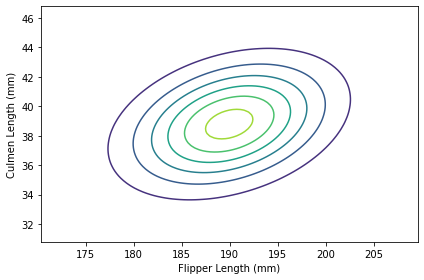

In [78]:
plot_contour(joint)
decorate(ylabel=var1,
         xlabel=var2)

In [79]:
def make_joint(norm1, norm2, multinorm):
    """
    """
    pmf1 = make_pmf(norm1)
    pmf2 = make_pmf(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    a = multinorm.pdf(pos)
    joint = pd.DataFrame(a, index=pmf1.qs, columns=pmf2.qs)
    return joint

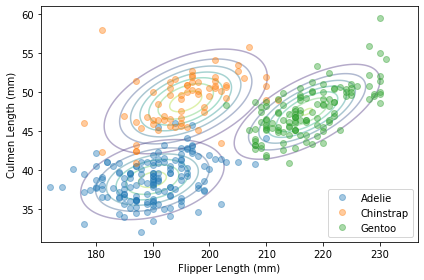

In [80]:
scatter_plot(df, var1, var2)

for species in hypos:
    norm1 = culmen_map[species]
    norm2 = flipper_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.4)

In [81]:
data = 38, 190
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.996771
Chinstrap,0.003068
Gentoo,0.000161


In [82]:
data = 48, 195
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.003101
Chinstrap,0.996877
Gentoo,0.000023


In [83]:
data = 48, 215
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.000046
Chinstrap,0.005243
Gentoo,0.994710


In [84]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[varnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

In [85]:
accuracy(df)

0.9532163742690059